In [5]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension('collapsible_headings/main') 

<IPython.core.display.Javascript object>

In [6]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import warnings
from collections import defaultdict
%matplotlib inline
from matplotlib import rcParams
plt.style.use('seaborn-whitegrid')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

# Import internal classes
from distributions import DistributionShift
from src.psi import psi
from tqdm.notebook import tqdm

In [7]:
from xgboost import XGBRegressor
from tabulate import tabulate

In [8]:
dataset_classes = [
    Airfoil,
    Concrete,
    #FishToxicity,
    #ForestFire,
    #NewTaipeiHousing,
    #PowerPlant,
    #Protein,
    #Servo,
]

In [9]:
for dataset in dataset_classes:
    print(dataset().shape)

(1503, 6)
(1030, 9)


In [10]:
def initialise_plot(
    num_rows: int, num_cols: int, base_regressor: type, dataset
):
    fig, axs = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        sharey=True,
        figsize=(14, 3.5 * num_rows),
    )
    fig.suptitle(
        f"Monitoring plot for the {dataset.__name__} dataset under feature drift with {base_regressor.__name__}",
        fontsize=16,
    )
    for j in range(num_cols):
        axs[num_rows - 1, j].set_xlabel("Sorted columnd index")
    for i in range(num_rows):
        axs[i, 0].set_ylabel("Normalised values")
    return fig, axs

In [11]:
def kol_smi(x):
    return ks_2samp(x, BASE_COMP).statistic
def psi_stat(x):
    return psi(x, BASE_COMP)

In [20]:
def monitoring_plot(dataset, base_regressor: type, n_boots: int = 20, **kwargs):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Initialise the scaler
        standard_scaler = StandardScaler()

        # Load the dataset and split it
        X, _, y, _ = dataset().split(test_size=0.001, random_seed=4242)

        # Scale the dataset
        X = standard_scaler.fit_transform(X)

        # Back to dataframe
        X = pd.DataFrame(X, columns=["Var %d" % (i + 1) for i in range(X.shape[1])])
        data = X.copy()
        data["target"] = y

        # Train test splitting points
        fracc = 0.33
        oneThird = int(data.shape[0] * fracc)
        twoThird = data.shape[0] - int(data.shape[0] * fracc)
        print(
            "Number of rows {}, 1split {}, 2nd split {}".format(
                data.shape[0], oneThird, twoThird
            )
        )

        # Initialize plots
        num_rows = X.shape[1] // 3
        if X.shape[1] % 3 > 0:
            num_rows += 1
        fig, axs = initialise_plot(
            num_rows=num_rows,
            num_cols=3,
            base_regressor=base_regressor,
            dataset=dataset,
        )

        uncertainty_res = []
        ks_res = []
        psi_res = []
        for idx, col in tqdm(enumerate(X.columns), total=len(X.columns)):
            values = defaultdict(list)

            # Sort data on the column
            data = data.sort_values(col).reset_index(drop=True).copy()

            # Train Test Split
            data_sub = data.iloc[:oneThird]
            data_train = data.iloc[oneThird:twoThird]
            data_up = data.iloc[twoThird:]

            X_tot = data.drop(columns="target")
            X_tr = data_train.drop(columns="target")
            X_sub = data_sub.drop(columns="target")
            X_up = data_up.drop(columns="target")

            y_tot = data[["target"]].target.values
            y_tr = data_train[["target"]].target.values
            y_sub = data_sub[["target"]].target.values
            y_up = data_up[["target"]].target.values

            # Fit the regressor
            regressor = Boot(base_regressor(**kwargs))
            regressor.fit(X_tr, y_tr, n_boots=20)

            # Predictions
            preds, intervals = regressor.predict(
                X_tot, uncertainty=0.05, n_boots=n_boots
            )
            # pre
            d_sub, interval_sub = regressor.predict(
                X_sub.values.astype(object), uncertainty=0.05, n_boots=n_boots
            )
            # pred_up, interval_up = regressor.predict(X_up, uncertainty=0.05, n_boots=n_boots)
            # pred_tr, interval_tr = regressor.predict(X_tr, uncertainty=0.05, n_boots=n_boots)
            # print("Sub:", np.round(mean_absolute_error(y_sub, pred_sub), decimals=2))
            # print("train:", np.round(mean_absolute_error(y_tr, pred_tr), decimals=2))
            # print("up:", np.round(mean_absolute_error(y_up, pred_up), decimals=2))
            # print("total:", np.round(mean_absolute_error(y_tot, preds), decimals=2))

            # print("Sub Uncertainty:", np.round(np.mean(interval_sub[:, 1] - interval_sub[:, 0]), decimals=2))
            # print("tr Uncertainty:", np.round(np.mean(interval_tr[:, 1] - interval_tr[:, 0]), decimals=2))
            # print("Up Uncertainty:", np.round(np.mean(interval_up[:, 1] - interval_up[:, 0]), decimals=2))
            # print("Total Uncertainty:", np.round(np.mean(intervals[:, 1] - intervals[:, 0]), decimals=2))

            # Statistics
            df = pd.DataFrame(
                intervals[:, 1] - intervals[:, 0], columns=["uncertainty"]
            )
            df["error"] = np.abs(preds - y_tot)

            # Rolling window
            ROLLING_STAT = int(df.shape[0] * 0.01)  ### WARNING ON THIS PARAMETER ###
            if ROLLING_STAT < 100:
                ROLLING_STAT = 100

            ### KS Test
            df["ks"] = data[col]
            global BASE_COMP
            BASE_COMP = data[col]
            df[["ks"]] = (
                df[["ks"]]
                .rolling(ROLLING_STAT * 2, int(ROLLING_STAT * 0.5))
                .apply(kol_smi)
            )  # Takes ages
            ### PSI Test
            df["PSI"] = data[col]
            df[["PSI"]] = (
                df[["PSI"]]
                .rolling(ROLLING_STAT * 2, int(ROLLING_STAT * 0.5))
                .apply(psi_stat)
            )  # Takes ages

            ### Rolling window on all
            df[df.columns[~df.columns.isin(["ks", "PSI"])]] = (
                df[df.columns[~df.columns.isin(["ks", "PSI"])]]
                .rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5))
                .mean()
            ).dropna()

            ## Scaling
            df = df.dropna()
            df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)

            # Convert to dic for plotting
            for index, col in enumerate(df.columns):
                values[col] = df[col]

            uncertainty_res.append(
                mean_absolute_error(values["error"], values["uncertainty"])
            )
            ks_res.append(mean_absolute_error(values["error"], values["ks"]))
            psi_res.append(mean_absolute_error(values["error"], values["PSI"]))

            # Plotting
            for name, vals in values.items():
                if idx == 0:
                    axs[idx // 3, idx % 3].plot(vals, label=f"{name} values")
                else:
                    axs[idx // 3, idx % 3].plot(vals)
        resultados = pd.DataFrame({"uncertainy": uncertainty_res, "ks": ks_res,'psi':psi_res})
        resultados.loc["mean"] = resultados.mean()
        print(resultados.to_string())

        fig.legend()
        # plt.savefig("fig.png")
        plt.show()

Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.669569  0.352089  0.629567
1       0.443735  1.122966  1.012187
2       0.700947  0.522469  0.978591
3       0.804332  1.096277  1.030768
4       0.781589  0.738446  0.571712
mean    0.680035  0.766449  0.844565


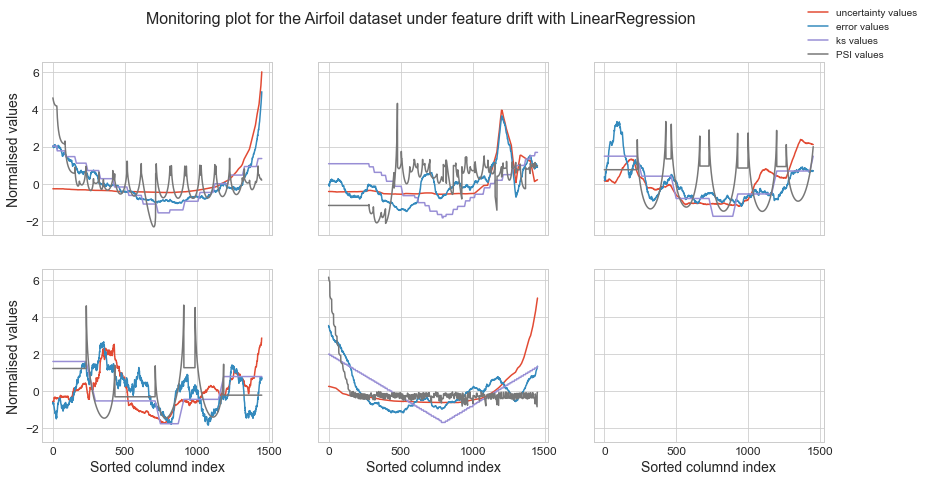

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.688634  0.921923  1.073541
1       0.558613  0.695903  0.639231
2       0.376230  1.038830  1.282468
3       0.741322  0.391809  0.473948
4       0.457922  0.596974  0.993253
5       0.889035  0.915267  0.836801
6       0.224837  0.554707  0.437377
7       0.931635  0.338486  0.489559
mean    0.608529  0.681737  0.778272


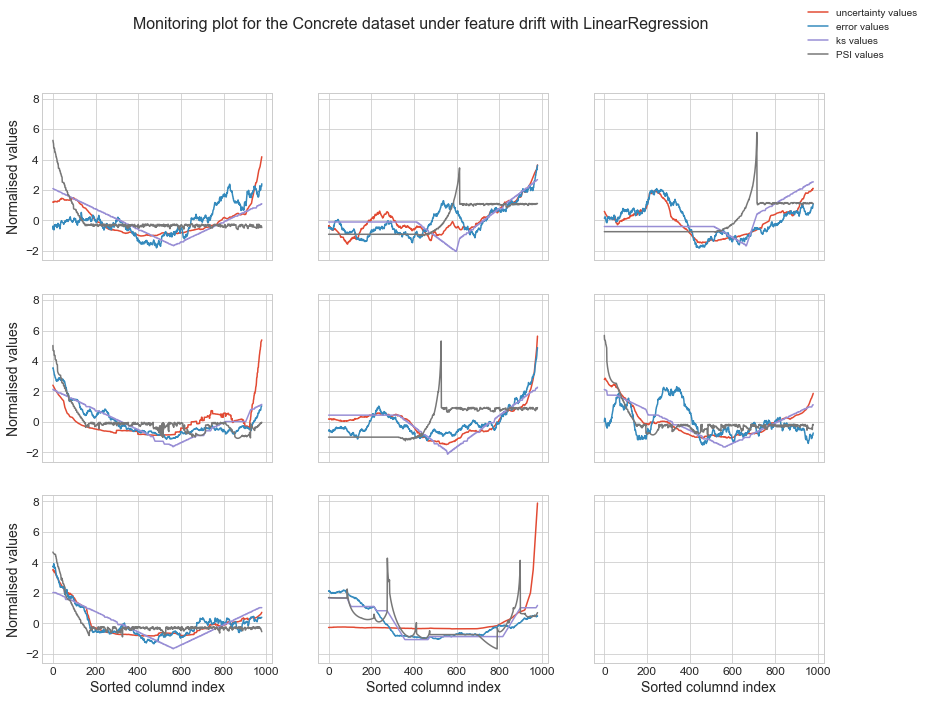

In [21]:
for dataset in dataset_classes:
    monitoring_plot(dataset, LinearRegression)

Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.667254  0.259373  0.748590
1       0.335625  0.594695  1.306111
2       0.259722  0.471757  1.022625
3       0.397427  0.769646  1.220921
4       0.390128  0.472509  1.074922
mean    0.410031  0.513596  1.074634


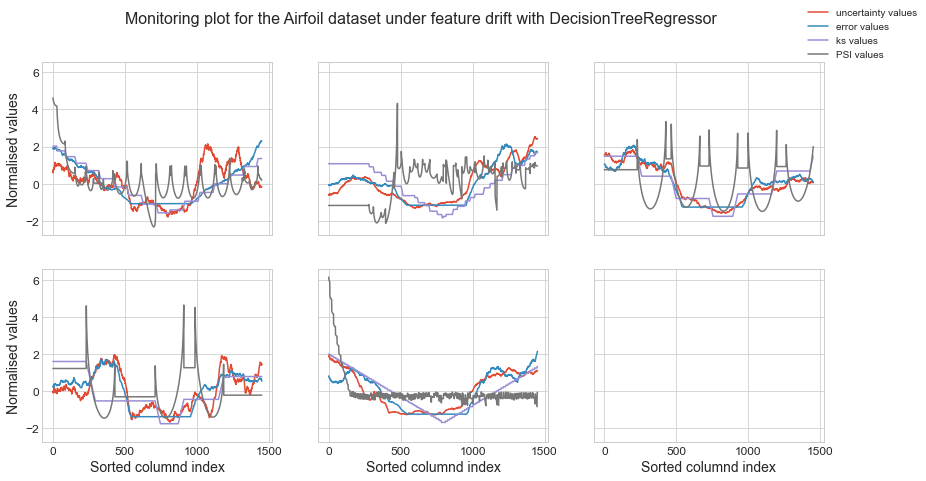

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.388914  0.466691  0.982422
1       0.283939  0.620791  1.085991
2       0.177710  0.879063  1.087388
3       0.295706  0.451748  0.974816
4       0.230936  0.505732  1.321853
5       0.383801  0.296986  0.939334
6       0.411816  0.297229  0.841936
7       0.868751  0.343875  0.519048
mean    0.380197  0.482765  0.969099


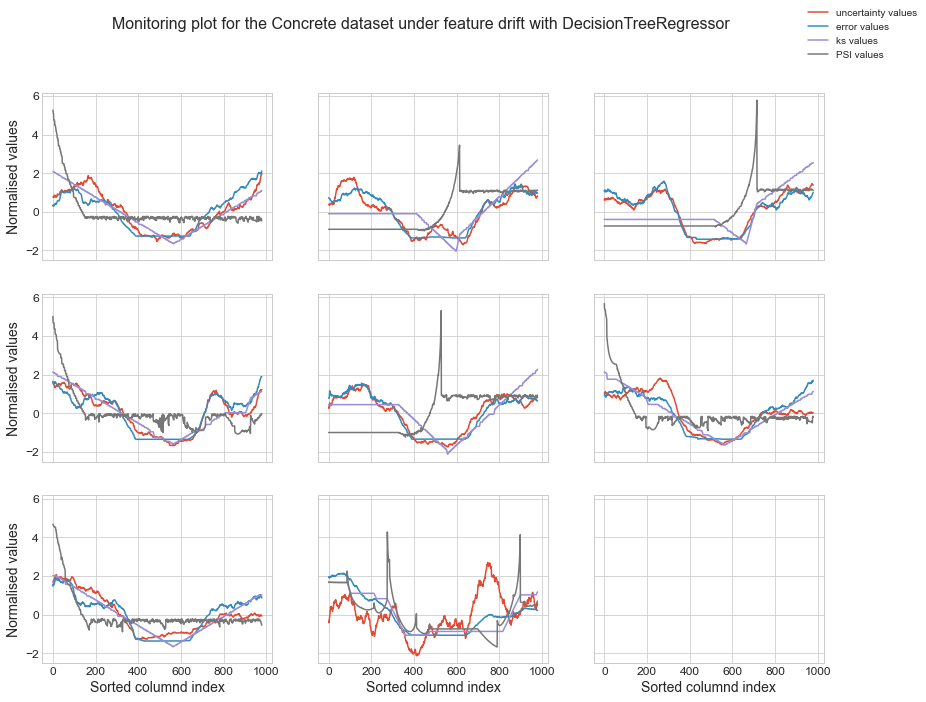

In [22]:
for dataset in dataset_classes:
    monitoring_plot(dataset, DecisionTreeRegressor,max_depth=20)
    #monitoring_plot(dataset,RandomForestRegressor)



Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

      uncertainy        ks       psi
0       0.819112  0.254992  0.731637
1       0.435503  0.730175  1.203788
2       0.499939  0.439675  1.019801
3       1.066600  0.772784  1.223245
4       0.411246  0.399809  0.899381
mean    0.646480  0.519487  1.015570


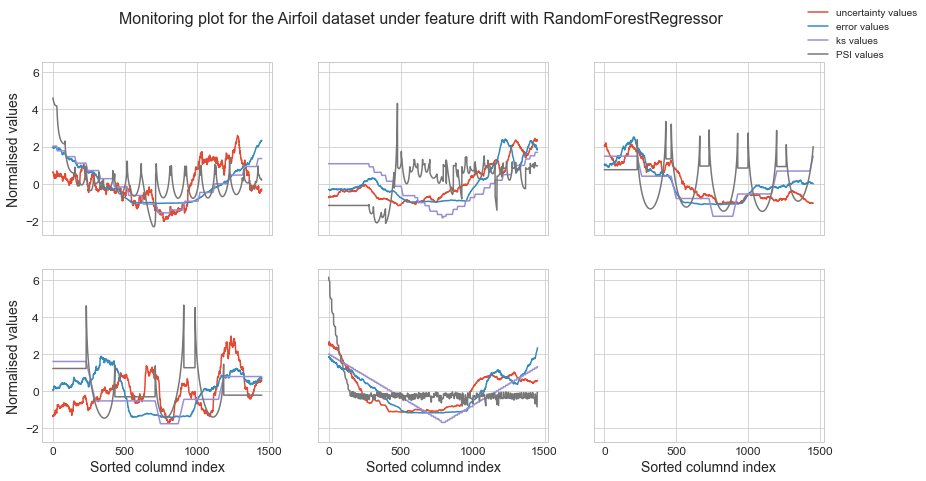

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,RandomForestRegressor)

